# Контроль качества данных

DQ (Data Quality, качество данных) - характеристика данных, показывающая степень их пригодности к анализу. Оценка качества данных – необходимый шаг любого проекта создания DWH.

Доверие к данным – краеугольный камень любого DWH.
(с) Ральф Кимбалл

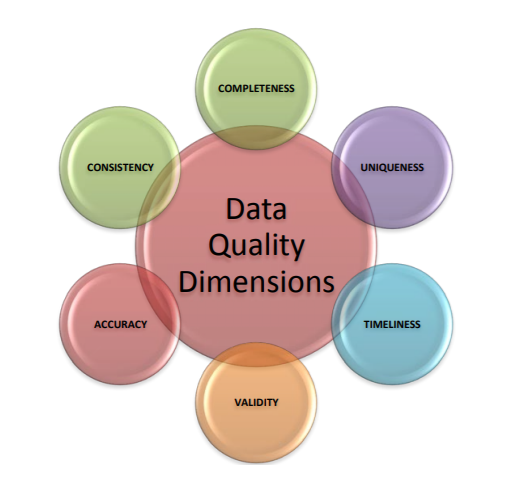

Критерии качества данных:
    
    • Своевременность
    • Согласованность
    • Точность
    • Полнота
    • Интерпретируемость
    • Уникальность

Своевременность - этот критерий выражает требование к регулярности загрузки данных в хранилище. Если требованиями определенно, что данные загружаются ежедневно, то данные отстающие на один день будут считаться не качественными.

Согласованность - этот критерий выражает требование к непротиворечивости данных, то есть данные не должны противоречить друг другу. Поскольку, зачастую, в хранилищах лежат рельные данные несогласованными будут являться, например две одинаковых записи о выполнении заказа с разными суммами оплаты. Такие ошибки зачастую связанны, либо с неправильным алгоритмом разложения исходной таблицы в модель данных, либо с некачественныи источником.

Точность (семантическая точность) - определяется как соответствие заданного значения реальному. Данный критерий применяется к количественным полям, может быть расчитан как среднеквадратичное отклонение по заданному полю за определенный промежуток времени. Либо другими статистическими методами для поиска выбросов. Данный критерий требует глубокого погружения в предметную область, чтобы понять являются ли выбросы в значениях сбоем в системе, либо же аномальными показателями.

Полнота - определяется как отношение количества непустых значений к общему количеству записей. Также полноту можно определить, как среднеквадратичное отклонение количества всех записей за определенный промежуток времени.

Интерпретируемость (синтаксическая точность) - этот критерий определяет совпадение значения атрибута со значением, принадлежащим предметной области. Другими словами, проверка на допустимость символом и/или соответсвие шаблону. Например, формат хранения номеров телефона. В разных источниках он хранится по разному (с тире, с плюсом, со скобками). Данные будут являться качественными, если мы приведем их все к единому формату.

Уникальность - определяется как отсутсвие дубликатов.

Инциденты DQ с точки зрения загрузки:

    • Критические – сбои в работе ETL процессов (ничего не загрузилось);
    • Не критические – сбои в данных, которые иногда не так просто отследить;

Модули проверки качества данных рассматривют не критические сбои в данных, посокльку функионал оповещений о критических инцедентах можно легко реализовать на уровне оркестраторов (пример: в аирфлоу параметр дага "email_on_failure": True)

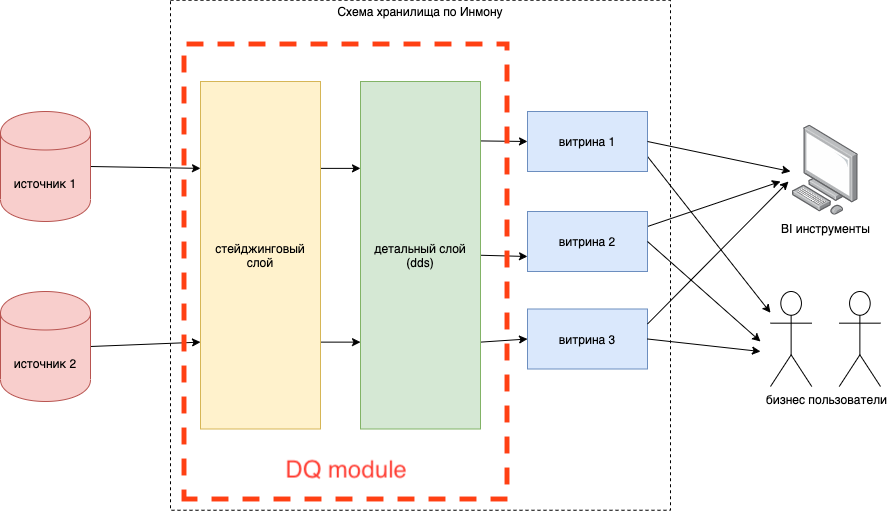

Я выделил Data quality в отдельный модуль, так как хорошей практикой будет не включать его в etl пайплайн. Это должна быть отдельная система проверок и поповещений (отдельный даг), которая никак не затрагивает основной пайплайн.

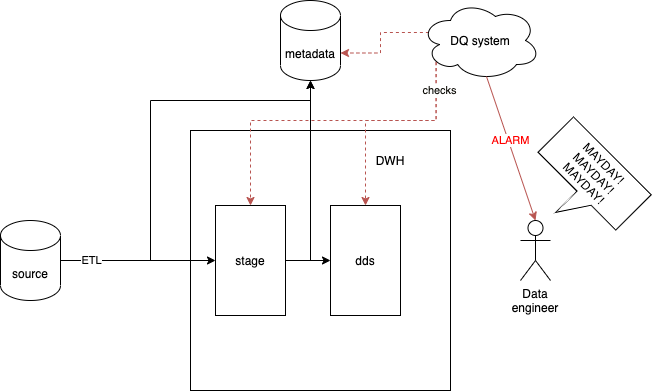

## Greate expectation

Great Expectations - это библиотека с открытым исходным кодом на основе Python для валидации, документирования и проверки данных.
https://docs.greatexpectations.io/en/latest/

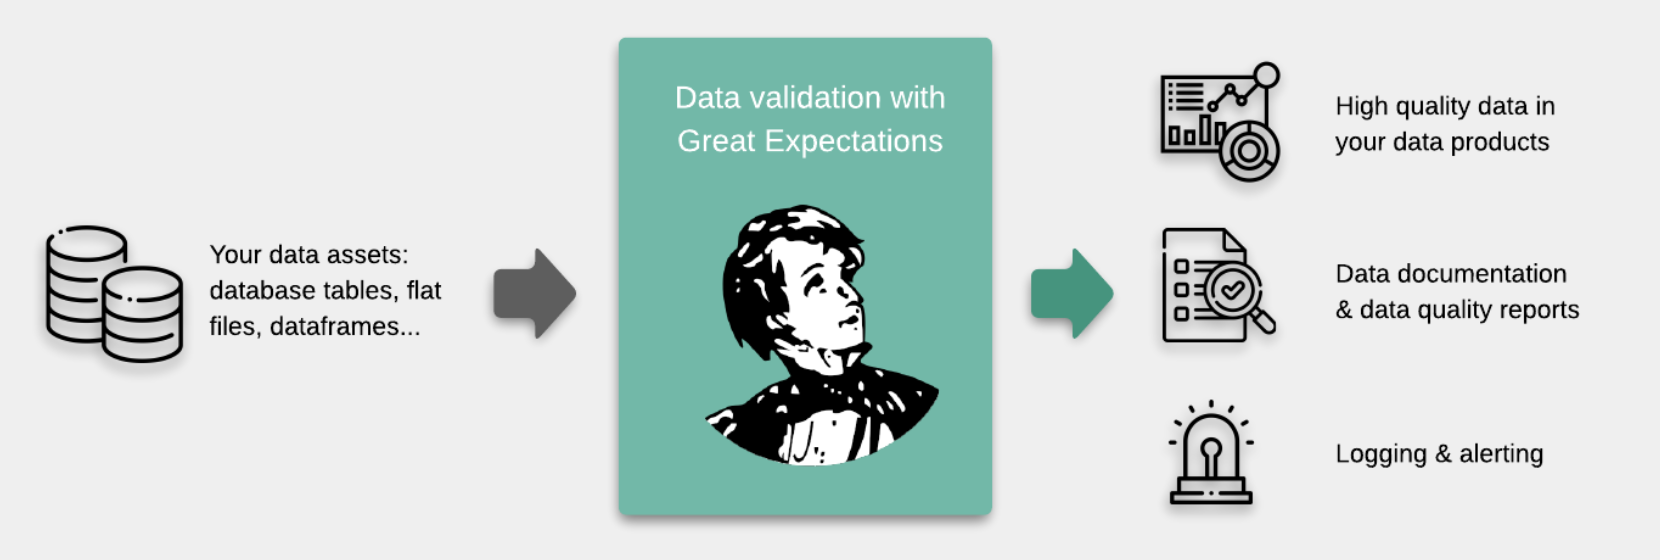

Что умеет Great Expectations:

    • создавать экпектейшены (параметры валидации данных в виде методов питона)
    • валидировать с помощью экспектейшенов данные
    • собирать базовые метрики по батчам данных (если не заданы никакие экспектейшены)
    • строить отчеты в html формате по результатам валидации (data docs)

Пример data docs:
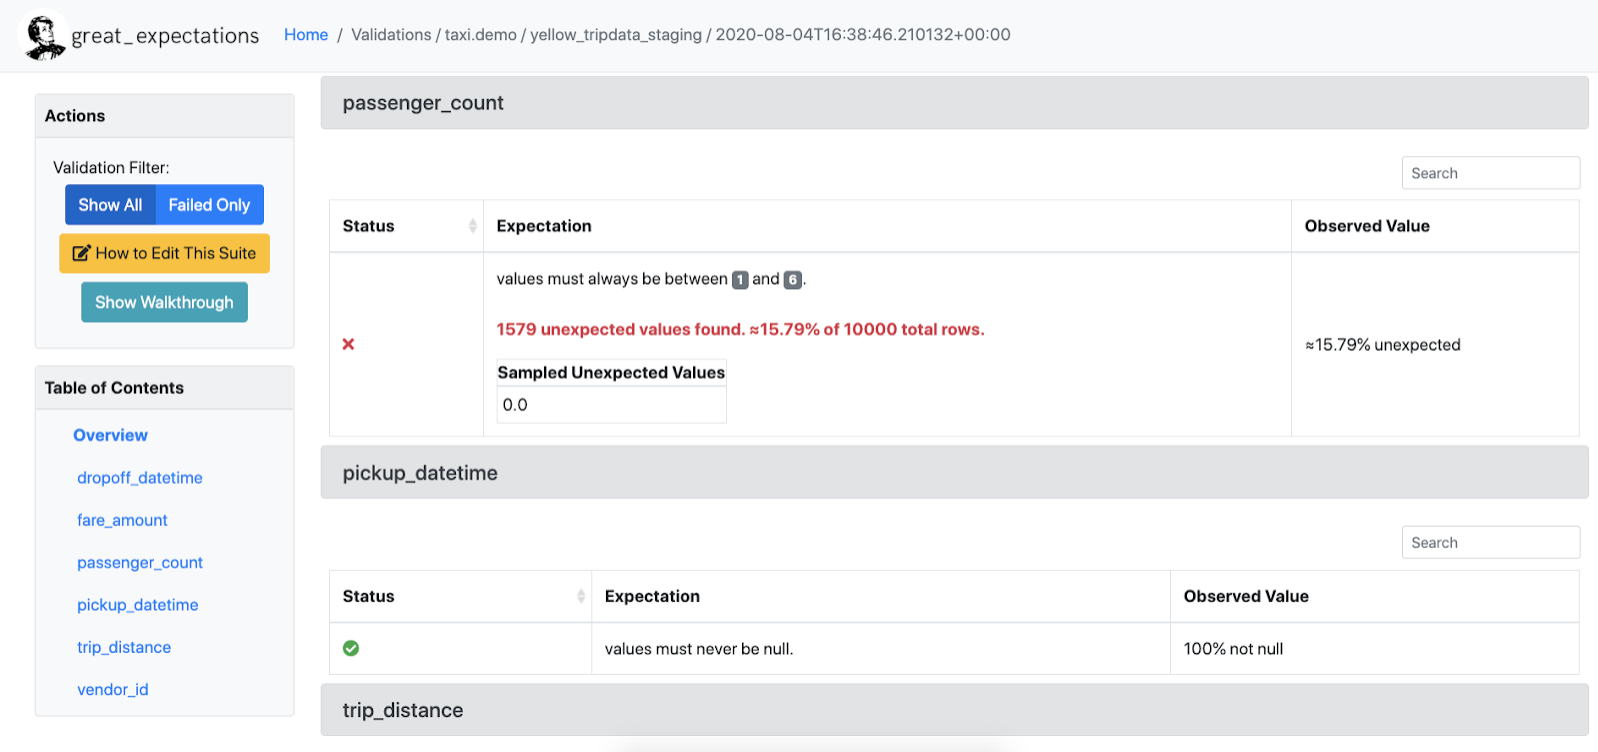

### Основные сущности Great Expectations

Datasource - сущность, которая отвечает за подключение к источнику данных для валидации (более высокоуровневая вариация - датасет).

Пример конфигурирования датасорса:
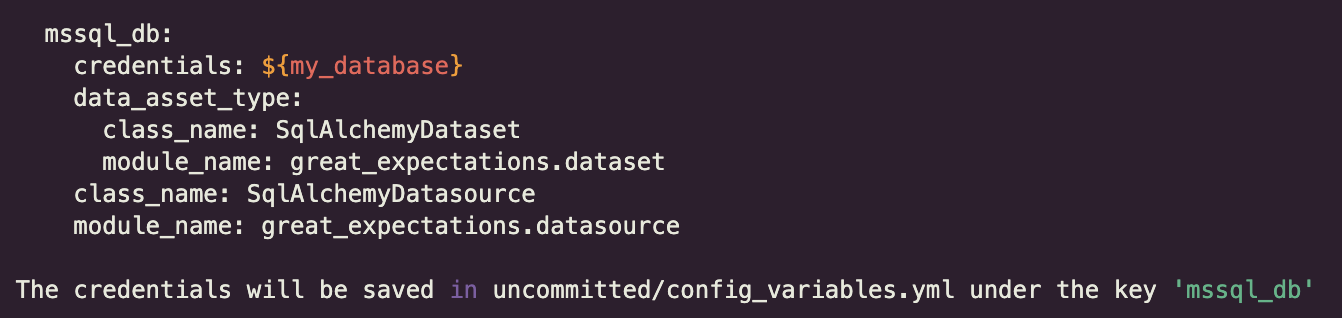

Можно опустить хардкод в ямл и перейти сразу к созданию датасета (сущности аналогичны в рамках либы):

In [ ]:
ds = SqlAlchemyDataset(
        engine=engine, # engine из алхимии
        table_name=table,
        schema=schema
    )

Когда мы определили какие данные будем валидировать, перейдем к созданию/определению экспектейшенов. Expectation - сущность, которая хранит в себе способы валидации данных и бенчмарки их выполнения.

Можно использовать уже готовые экспектейшены из либы (они являются методами датасета), либо написать свои.

In [ ]:
ds.expect_column_values_to_not_be_null('vk_id') # готовый экспектейшен из коробки

Его возвращаемое значение:

In [ ]:
{
  "result": {
    "element_count": 4003291,
    "unexpected_count": 1000513,
    "unexpected_percent": 25.0,
    "partial_unexpected_list": []
  },
  "success": false,
  "meta": {},
  "exception_info": null
}

Кастомный экспектейшн определяется как метод датасета. Если мы определяем экспектейшен для колонки, то название метода должно обязательно начинаться с "expect_column_". Это важно, иначе у вас все будет крашится.

In [ ]:
from great_expectations.dataset import MetaSqlAlchemyDataset
from great_expectations.dataset.sqlalchemy_dataset import SqlAlchemyDataset

class DWHSqlAlchemyDataset(SqlAlchemyDataset):
    _data_asset_type = "DWHSqlAlchemyDataset"

    @MetaSqlAlchemyDataset.column_aggregate_expectation
    def expect_column_proportion_of_unique_values_to_be_between_vertica(
        self,
        column,
        min_value=0,
        max_value=1,
        strict_min=False,
        strict_max=False,
    ):
        _column = self.engine.dialect.identifier_preparer.quote(column)

        query_distinct = sa_text(f"""
            select count(distinct {_column}) from {self._table}
        """)
        query_count = sa_text(f"""
            select count({_column}) from {self._table}
        """)

        count_distinct: int = self.engine.execute(query_distinct, column=column).scalar()
        row_count: int = self.engine.execute(query_count, column=column).scalar()

        if not row_count:
            proportion_unique = 0
            success = True
        else:
            proportion_unique = float(count_distinct) / row_count
            greater = float.__gt__ if strict_min else float.__ge__
            less = float.__lt__ if strict_max else float.__le__
            success = greater(proportion_unique, min_value) and less(proportion_unique, max_value)

        return {
            "success": success, # сюда вставляем результат проверки условия
            "result": {
                "observed_value": proportion_unique, # сюда вставляем значение экспекта
            }
        }

Теперь у нас есть заготовки для прогона проверок и валидаций над данными. Для того чтобы запускать все написанное выше, нужно определить конфиг либы.

Datacontext - сущность, в которой хранится конфигурационная информация о всех хранилищах, предписанных действиях для разных сущностей и много всего. Можно создавать датаконтекст на лету, а можно хранить в файле.

In [ ]:
from great_expectations.data_context.types.base import DataContextConfig
from great_expectations.data_context import BaseDataContext

datacontext = {
        'config_version': 3,
        'plugins_directory': None,
        'config_variables_file_path': None,
        'stores': {
            "expectations_store": {
                "class_name": "ExpectationsStore",
                "store_backend": {
                    "class_name": "DatabaseStoreBackend",
                    "credentials": {
                        "drivername": "postgresql",
                        "schema": "dq",
                        "connect_args": {
                            "host": "host",
                            "port": port,
                            "database": "db",
                            "user": "user",
                            "krbsrvname": "krbsrvname",
                        }
                    },
                },
            },
            "validations_store": {
                "class_name": "ValidationsStore",
                "store_backend": {
                    "class_name": "DatabaseStoreBackend",
                    "credentials": {
                        "drivername": "postgresql",
                        "schema": "dq",
                        "connect_args": {
                            "host": "host",
                            "port": port,
                            "database": "db",
                            "user": "user",
                            "krbsrvname": "krbsrvname",
                        }
                    },
                },
            },
            "metrics_store": {
                "class_name": "MetricStore",
                "store_backend": {
                    "class_name": "DatabaseStoreBackend",
                    "credentials": {
                        "drivername": "postgresql",
                        "schema": "dq",
                        "connect_args": {
                            "host": "host",
                            "port": port,
                            "database": "db",
                            "user": "user",
                            "krbsrvname": "krbsrvname",
                        }
                    },
                },
            },
            "evaluation_parameter_store": {"class_name": "EvaluationParameterStore"},
        },
        'data_docs_sites': {
            "local_site": {
                "class_name": "SiteBuilder",
                "store_backend": {
                    "class_name": "TupleFilesystemStoreBackend",
                    "base_directory": "/usr/local/airflow/airflow/dags/indexes",
                },
                "site_index_builder": {
                    "class_name": "DefaultSiteIndexBuilder",
                    "show_cta_footer": False,
                },
            }
        },
        'expectations_store_name': "expectations_store",
        'validations_store_name': "validations_store",
        'evaluation_parameter_store_name': "evaluation_parameter_store",
        'validation_operators': {
            "action_list_operator": {
                "class_name": "ActionListValidationOperator",
                "action_list": [
                    {
                        "name": "store_validation_result",
                        "action": {"class_name": "StoreValidationResultAction"},
                    },
                    {
                        "name": "store_evaluation_params",
                        "action": {"class_name": "StoreEvaluationParametersAction"},
                    },
                    {
                        "name": "update_data_docs",
                        "action": {"class_name": "UpdateDataDocsAction"},
                    },
                    {
                        "name": "store_metrics",
                        "action": {
                            "class_name": "StoreMetricsAction",
                            "target_store_name": "metrics_store",
                            "requested_metrics": {
                                "*": [
                                    {
                                        'column': {
                                            col: metric
                                        }
                                    }
                                ]
                            }
                        }
                    }
                ],
            }
        },
        'anonymous_usage_statistics': {
            "enabled": False
        }

data_context_config = DataContextConfig(
    **datacontext
)

context = BaseDataContext(project_config=data_context_config)

Чтобы все работало, мы обязательно должны валидно задать все параметры для хранилищ (***_store). По соответсвующим путям/хостам библиотека будет хранить артефакты (экпектейшены, метрики, статистику, результаты валидаций, data docs и тд).

Соберем все это воедино и запустим great_expectation в аирфлоу:

In [ ]:
import logging
import pendulum
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime
from great_expectations.data_context import BaseDataContext
from great_expectations.data_context.types.base import DataContextConfig
from airflow.utils.state import State
import sqlalchemy as sa
import dq_utils # сюда вынесены датаконтекст, кастомные датасеты, кастомные конфиги и прочие конфигурационные штучки


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": pendulum.datetime(year=2021, month=4, day=13, tz="Europe/Moscow"),
    "retries": 0,
    "email_on_failure": False,
    "on_failure_callback": False,
    "email_on_retry": False,
    "depends_on_past": False,
    "wait_for_downstream": False,
}

url = url
default_metrics = [
    "expect_column_count_distinct.result.observed_value",
    "expect_column_proportion_of_unique_values_to_be_between_vertica.result.observed_value",
    "expect_column_uniqueness_to_be_between.result.observed_value",
    "expect_column_values_to_not_be_null.result.unexpected_percent"
]


def validate(table, schema):
    engine = sa.create_engine(url)
    data_context_config = DataContextConfig(
        **dq_utils.get_datacontext_dict(table, default_metrics) # параметризированный датаконтекст
    )

    context = BaseDataContext(project_config=data_context_config)
    ds = dq_utils.DWHSqlAlchemyDataset(
        engine=engine,
        table_name=table,
        schema=schema
    )

    logging.info('Dataset created')

    if ds.get_row_count() == 0:
        logging.info('Table is empty')
        return

    for column in dq_utils.sal_conf[table]['keys']:
        ds.expect_column_count_distinct(column)
        ds.expect_column_proportion_of_unique_values_to_be_between_vertica(column)

    logging.info('Expectations for keys added')

    for column in dq_utils.sal_conf[table]['sats']:
        ds.expect_column_values_to_not_be_null(column)
        ds.expect_column_uniqueness_to_be_between(column)
        ds.expect_column_proportion_of_unique_values_to_be_between_vertica(column)
        ds.expect_column_count_distinct(column)

    logging.info('Expectations for other columns added')
    dt = str(datetime.now().date())
    run_id = f'{schema}.{table}_{dt}'

    res = context.run_validation_operator(
        "action_list_operator",
        assets_to_validate=[ds],
        run_id=run_id
    )

    logging.info(res)


with DAG(
    dag_id="dq-sal",
    default_args=DEFAULT_ARGS,
    user_defined_macros=USER_DEFINITION_MACROS,
    catchup=False,
    tags=['dq'],
    schedule_interval="@daily",
    max_active_runs=1,
) as dag:
    for table in dq_utils.sal_conf:
        sensor = ExternalTaskSensor(
            task_id=task_id,
            external_dag_id=external_dag_id,
            external_task_id=external_task_id,
            check_existence=False,
            mode='reschedule',
            poke_interval=60 * 60,
            timeout=60 * 60 * 20,
            soft_fail=True,
            allowed_states=[State.SUCCESS],
            retries=0,
        )

        validate_operator = PythonOperator(
            task_id=f'{table}',
            python_callable=validate,
            op_kwargs={'table': table, 'schema': schema},
            retries=2,
        )

        sensor >> validate_operator


# Метаданные

Для эффективного контроля за etl процессами, нам понадобится хранить метаданные о них.

Хорошей практикой будет хранение метаданных и логов в СУБД отличной от той, где находится хранилище. Это позволит изолировать их друг от друга. И при поломке одного компонента не будут затронуты остальные.

Для нашего удобвства создадим таблицу с логами в целевом постгресе:

In [6]:
import psycopg2

q = """
create table log (
       source_launch_id    int
     , target_schema       text
     , target_table        text  
     , target_launch_id    int
     , processed_dttm      timestamp default now()
     , row_count           int
     , duration            interval
     , load_date           date
)
"""


conn_string= "host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'" 
with psycopg2.connect(conn_string) as conn, conn.cursor() as cursor:
    cursor.execute(q)


Комментарии по полям:
    
    • source_launch_id, target_launch_id - нужны для отслеживания изменения уникальных идентфификаторов тасков
    • target_schema, target_table - с какой схемой, таблицей работаем
    • processed_dttm - время записи лога
    • row_count - сколько строк заинсертилось
    • duration - продолжительность таска
    • load_date - дата загрузки (не всегда равно processed_dttm, так как можем перезапускать таски из прошлого)

Также создадим таблицу для сбора статистики:

In [8]:
import psycopg2

q = """
create table statistic (
       table_name     text
     , column_name    text
     , cnt_nulls      int
     , cnt_all        int
     , load_date      date
)
"""

conn_string= "host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'" 
with psycopg2.connect(conn_string) as conn, conn.cursor() as cursor:
    cursor.execute(q)

Комментарии по полям:
    
    • table_name, column_name - имя таблицы, колонки
    • cnt_nulls - количество наллов в колонке
    • cnt_all - количество строк в колонке
    • load_date - дата загрузки

Дополнительные поля в нашем хранилище (у всех таблиц):
    
    • launch_id (уникальный идентификатор таска)
    • effective_dttm (дата загрузки, default now())

Создадим файл utils.py, в котором будут хранится различные методы для сбора статистики, записи логов и проверки статуса загрузки данных:

In [ ]:
import psycopg2
import logging
from airflow.models import BaseOperator

class DataFlowBaseOperator(BaseOperator):
    def __init__(self, pg_meta_conn_str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pg_meta_conn_str = pg_meta_conn_str

    def write_etl_log(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            insert into log (
                   source_launch_id
                 , target_schema
                 , target_table
                 , target_launch_id
                 , row_count
                 , duration
                 , load_date
            )
            select {launch_id}
                , '{target_schema}'
                , '{target_table}'
                , {job_id}
                , {row_count}
                , '{duration}'
                , '{dt}'
            '''
            cursor.execute(query.format(**config))
            logging.info('Log update: {target_table} : {job_id}'.format(**config))
            conn.commit()


    def write_etl_statistic(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            insert into statistic (
                   table_name
                 , column_name
                 , cnt_nulls
                 , cnt_all
                 , load_date
            )
            with x as (
                select '{table}' as table_name
                     , '{column}' as column_name
                     , {cnt_nulls} as cnt_nulls
                     , {cnt_all} as cnt_all
                     , {launch_id} as launch_id
            )
            select table_name
                 , column_name
                 , cnt_nulls
                 , cnt_all
                 , load_date
              from x left join log l
                on x.launch_id = l.target_launch_id
            '''
            cursor.execute(query.format(**config))
            conn.commit()


    def get_load_dates(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            select array_agg(distinct load_date order by load_date)
                from log
                where target_table = '{target_table}'
                and target_schema = '{target_schema}'
                and source_launch_id = -1
            '''
            cursor.execute(query.format(**config))
            dates = cursor.fetchone()[0]
        if dates:
            return dates
        else:
            return []


Модифицируем код data_transfer.py, добавив методы записи логов и проверку загрузки за определенную дату:

In [ ]:
import logging
import os
import time
import psycopg2
from contextlib import contextmanager
from airflow.models import BaseOperator
from airflow.utils.decorators import apply_defaults
from operators.utils import DataFlowBaseOperator


class DataTransfer(DataFlowBaseOperator): # modify
    @apply_defaults
    def __init__(self, config, pg_conn_str, pg_meta_conn_str, date_check=False, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.pg_conn_str = pg_conn_str
        self.pg_meta_conn_str = pg_meta_conn_str
        self.date_check = date_check

    def provide_data(self, csv_file, context):
        pass

    def execute(self, context):
        copy_statement = """
        COPY {target_schema}.{target_table} ({columns}, launch_id as {job_id}) FROM STDIN with
        DELIMITER '\t'
        CSV
        ESCAPE '\\'
        NULL '';
        """
        schema_name = "{table}".format(**self.config).split(".")
        self.config.update( 
            target_schema=schema_name[0],
            target_table=schema_name[1],
            job_id=context["task_instance"].job_id, # modify
            dt=context["task_instance"].execution_date, # modify
        )
        # modify
        if self.date_check and context["execution_date"] in self.get_load_dates(
            self.config
        ):
            logging.info("Data already load")
            return
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:
            start = time.time() # modify
            # modify
            cursor.execute(
                """
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}'
               and column_name not in ('launch_id', 'effective_dttm');
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)

            with open("transfer.csv", "w", encoding="utf-8") as csv_file:
                self.provide_data(csv_file, context)

            self.log.info("writing succed")

            with open('transfer.csv', 'r', encoding="utf-8") as f:
                cursor.copy_expert(copy_statement.format(**self.config), f)

            self.config.update( # modify
                launch_id=-1,
                duration=datetime.timedelta(seconds=time.time() - start),
                row_count=cursor.rowcount
            )
            self.write_etl_log(self.config) # modify
            

Код дага тоже модифицируем, так как мы добавили новый атрибут класса "pg_meta_conn_str":

In [ ]:
from airflow import DAG
from operators.postgres import DataTransferPostgres
from datetime import datetime


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 25),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": True,
}

with DAG(
    dag_id="pg-data-flow",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    t1 = DataTransferPostgres(
        config={'table': 'public.customer'},
        query='select * from customer'
        task_id='customer',
        source_pg_conn_str="host='db2' port=5432 dbname='tpch' user='postgres' password='postgres'",
        pg_conn_str="host='db1' port=5432 dbname='my_database2' user='admin' password='postgres'",
        pg_meta_conn_str="host='db1' port=5432 dbname='my_database2' user='admin' password='postgres'", # modify
    )

Подведем итоги:

    • познакомились с понятием Data quality и метаданные
    • узнали какие есть метрики и методы для оценки качества данных
    • реализовали оператор для записи логов, сбора статистики и проверки загрузки данных
    • модифицировали код базового оператора, теперь он пишет лог и делает проверку были ли загружены данные

Источники:

    • https://www.psycopg.org/docs/cursor.html
    • http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1807-17752020000100303
    • https://www.edq.com/glossary/data-quality/

## Домашнее задание

1) Написать оператор для сбора статистики в таблицу statistic. Метод записи из utils.py: def write_etl_statistic().
<br>2) Создать отдельный даг с этим оператором. Перед сбором статистики должен быть external_task_sensor на успешное выполнение переливки данных. Документация по сенсору: https://airflow.apache.org/docs/apache-airflow/1.10.4/_api/airflow/sensors/external_task_sensor/index.html